<a href="https://colab.research.google.com/github/Jundo22l/CAU_internship/blob/main/U_NET_with_VOC(ver2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn.functional as F
from torchvision.models import vgg16
import torchvision.transforms.functional as TVF
import glob

# 문제 발생 시 CUDA 동기적으로 에러 출력
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
# 데이터셋 다운로드 및 압축 해제
!wget -q http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
!tar -xf VOCtrainval_11-May-2012.tar

# COLOR_2_INDEX 및 CLASS_NAMES 정의 (PASCAL VOC 2012)
COLOR_2_INDEX = {
    (0, 0, 0): 0,            # Background
    (128, 0, 0): 1,          # Aeroplane
    (0, 128, 0): 2,          # Bicycle
    (128, 128, 0): 3,        # Bird
    (0, 0, 128): 4,          # Boat
    (128, 0, 128): 5,        # Bottle
    (0, 128, 128): 6,        # Bus
    (128, 128, 128): 7,      # Car
    (64, 0, 0): 8,           # Cat
    (192, 0, 0): 9,          # Chair
    (64, 128, 0): 10,        # Cow
    (192, 128, 0): 11,       # Dining Table
    (64, 0, 128): 12,        # Dog
    (192, 0, 128): 13,       # Horse
    (64, 128, 128): 14,      # Motorbike
    (192, 128, 128): 15,     # Person
    (0, 64, 0): 16,          # Potted Plant
    (128, 64, 0): 17,        # Sheep
    (0, 192, 0): 18,         # Sofa
    (128, 192, 0): 19,       # Train
    (0, 64, 128): 20         # TV/Monitor
}
CLASS_NAMES = ["Background", "Aeroplane", "Bicycle", "Bird", "Boat", "Bottle", "Bus", "Car", "Cat", "Chair", "Cow",
               "Dining Table", "Dog", "Horse", "Motorbike", "Person", "Potted Plant", "Sheep", "Sofa", "Train", "TV/Monitor"]

In [5]:
class PascalVoc(Dataset):
    def __init__(self, path, img_size, device="cuda"):
        self.seg_folder = "SegmentationClass/"
        self.img_folder = "JPEGImages/"
        self.path = path
        self.device = device

        self.segmentation_imgs = glob.glob(os.path.join(path, self.seg_folder, "*"))
        self.img_size = img_size  # 이미지 크기 설정

    def __len__(self):
        return len(self.segmentation_imgs)

    def get_paths(self, idx):
        mask_path = self.segmentation_imgs[idx]  # 인덱스에 해당하는 마스크 이미지 경로

        file_name = mask_path.split("/")[-1]
        img_path = os.path.join(self.path, self.img_folder, file_name.split(".")[0] + ".jpg")
        return (img_path, mask_path)

    def load_imgs(self, idx):
        img_path, mask_path = self.get_paths(idx)
        #지정된 크기로 리사이즈
        img = Image.open(img_path)
        img = img.resize((self.img_size, self.img_size))
        #RGB로 변환한 후 지정된 크기로 리사이즈한다.
        mask_img = Image.open(mask_path).convert("RGB")
        mask_img = mask_img.resize((self.img_size, self.img_size))
        # 튜플로 반환
        return (img, mask_img)

    @staticmethod
    def create_label_mask(mask_img):
        # 마스크 이미지를 정수형 NumPy 배열로 변환하고, 레이블 마스크를 생성한다.
        mask = np.array(mask_img).astype(int)
        label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int16)
        for idx, label in enumerate(COLOR_2_INDEX):
            label_mask[np.where(np.all(mask == label, axis=-1))[:2]] = idx

        label_mask = label_mask.astype(int)
        return label_mask

    def __getitem__(self, idx):
        img, mask_img = self.load_imgs(idx)  # 이미지와 마스크를 로드한다.
        if random.random() > 0.5:
            img = TVF.hflip(img)
            mask_img = TVF.hflip(mask_img)
        mask_img = PascalVoc.create_label_mask(mask_img)
        mask_img = torch.from_numpy(mask_img).long()
        img = TVF.to_tensor(img)
        img = TVF.normalize(img,
                            mean=(0.485, 0.456, 0.406),
                            std=(0.229, 0.224, 0.225)
                           )
        img = img.to(self.device)
        mask_img = mask_img.to(self.device)
        return (img, mask_img)

In [6]:
# 2D 합성곱 & 배치 레이어를 정의
class conv2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):

        x = self.conv(x)
        x = F.relu(x)
        x = self.bn(x)
        return x

class trans_conv2d(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.ConvTranspose2d(in_channels, out_channels,
                                       kernel_size=3, stride=2,
                                       padding=1, output_padding=1)

        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = F.relu(x)
        x = self.bn(x)
        return x

In [7]:
class u_net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # U-Net의 출력 클래스 수를 정의한다.
        self.num_classes = num_classes
        self.un_block_indicies = [(0, 4), (5, 9), (10, 16),
                                   (17, 23), (24, 30)]

        self.init_vgg()
        self.conv_7x7_1 = conv2d(512, 512)
        self.conv_7x7_2 = conv2d(512, 512)

        self.trans_conv_1 = trans_conv2d(512, 256)
        self.trans_conv_2 = trans_conv2d(512, 256)
        self.trans_conv_3 = trans_conv2d(512, 128)
        self.trans_conv_4 = trans_conv2d(256, 64)
        self.trans_conv_5 = trans_conv2d(128, 32)

        self.conv_1 = conv2d(256 + 512, 512)
        self.conv_2 = conv2d(256 + 512, 512)
        self.conv_3 = conv2d(128 + 256, 256)
        self.conv_4 = conv2d(64 + 128, 128)
        self.out_conv = nn.Conv2d(32 + 64, num_classes, stride=1, kernel_size=1)

    def init_vgg(self):
        model = vgg16(pretrained=True)
        del model.classifier
        model = model.to(device)

        self.blocks = []

        for block_idx in self.un_block_indicies:
            self.blocks.append(model.features[block_idx[0]:block_idx[1]])

        for block in self.blocks:
            for param in block.parameters():
                param.requires_grad = False

    def forward(self, x):
        x_1 = self.blocks[0](x)
        encoder = F.max_pool2d(x_1, kernel_size=2, stride=2)
        x_2 = self.blocks[1](encoder)
        encoder = F.max_pool2d(x_2, kernel_size=2, stride=2)
        x_3 = self.blocks[2](encoder)
        encoder = F.max_pool2d(x_3, kernel_size=2, stride=2)
        x_4 = self.blocks[3](encoder)
        encoder = F.max_pool2d(x_4, kernel_size=2, stride=2)
        x_5 = self.blocks[4](encoder)
        encoder = F.max_pool2d(x_5, kernel_size=2, stride=2)

        encoder = self.conv_7x7_1(encoder)
        encoder = self.conv_7x7_2(encoder)

        decoder = self.trans_conv_1(encoder)
        decoder = torch.cat((decoder, x_5), dim=1)
        decoder = self.conv_1(decoder)

        decoder = self.trans_conv_2(decoder)
        decoder = torch.cat((decoder, x_4), dim=1)
        decoder = self.conv_2(decoder)

        decoder = self.trans_conv_3(decoder)
        decoder = torch.cat((decoder, x_3), dim=1)
        decoder = self.conv_3(decoder)

        decoder = self.trans_conv_4(decoder)
        decoder = torch.cat((decoder, x_2), dim=1)
        decoder = self.conv_4(decoder)

        decoder = self.trans_conv_5(decoder)
        decoder = torch.cat((decoder, x_1), dim=1)
        decoder = self.out_conv(decoder)

        score = F.log_softmax(decoder, dim=1)
        return score

In [8]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.cuda.amp as amp

# 시드 설정
seed = 42
torch.manual_seed(seed)

# 하드웨어 장치 설정
device = "cuda" if torch.cuda.is_available() else "cpu"

# 이미지 크기 및 배치 크기 설정
img_size = 224
batch_size = 32

# PascalVoc 데이터셋을 불러오고 DataLoader를 설정
train_dataset = PascalVoc("VOCdevkit/VOC2012/", img_size, device=device)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=0)

# u_net 모델 정의 및 클래스 수에 맞게 초기화
model = u_net(len(CLASS_NAMES)).to(device)

# 학습 설정
learning_rate = 2e-3  # 초기 학습률
weight_decay = 1e-5  # L2 정규화
momentum = 0.9  # RMSprop 모멘텀
amp_enabled = True  # 혼합 정밀도 학습

# 옵티마이저를 RMSprop으로 설정 (기존 Adam에서 변경)
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum, foreach=True)

# 학습률 스케줄러를 ReduceLROnPlateau로 설정
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5)

grad_scaler = amp.GradScaler(enabled=amp_enabled)

# 손실 함수 설정: 클래스 개수에 따라 CrossEntropy 또는 BCEWithLogits 선택
criterion = nn.CrossEntropyLoss() if model.num_classes > 1 else nn.BCEWithLogitsLoss()

# IoU 계산 함수 정의
def batch_mean_iou(preds, labels):
    intersection = np.logical_and(preds, labels)  # 교집합 계산
    union = np.logical_or(preds, labels)  # 합집합 계산
    iou_score = np.sum(intersection) / np.sum(union)  # IoU 계산
    return iou_score

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 86.9MB/s]
<ipython-input-8-c4c25bcdf9ed>:39: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  grad_scaler = amp.GradScaler(enabled=amp_

<ipython-input-9-0016bba84032>:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(enabled=amp_enabled):


-------Epoch 1-------
Loss : 1.0091002194777778
Mean IOU: 0.40880824651495495
-------Epoch 2-------
Loss : 0.7173775272524875
Mean IOU: 0.49135544991752433
-------Epoch 3-------
Loss : 0.6516031823728395
Mean IOU: 0.5215740071975205
-------Epoch 4-------
Loss : 0.6154924478867779
Mean IOU: 0.5401183447996484
-------Epoch 5-------
Loss : 0.579309741763965
Mean IOU: 0.558501214849114
-------Epoch 6-------
Loss : 0.5460697558263073
Mean IOU: 0.5719670450383972
-------Epoch 7-------
Loss : 0.5200319610860037
Mean IOU: 0.5832510734551326
-------Epoch 8-------
Loss : 0.4928255524972211
Mean IOU: 0.5961103840106949
-------Epoch 9-------
Loss : 0.47458590469930484
Mean IOU: 0.6075972004100251
-------Epoch 10-------
Loss : 0.45685500716385635
Mean IOU: 0.6136566645044129
-------Epoch 11-------
Loss : 0.4402901847725329
Mean IOU: 0.6238538360531486
-------Epoch 12-------
Loss : 0.4260892288192459
Mean IOU: 0.6331532553229255
-------Epoch 13-------
Loss : 0.41255161522523215
Mean IOU: 0.639792514

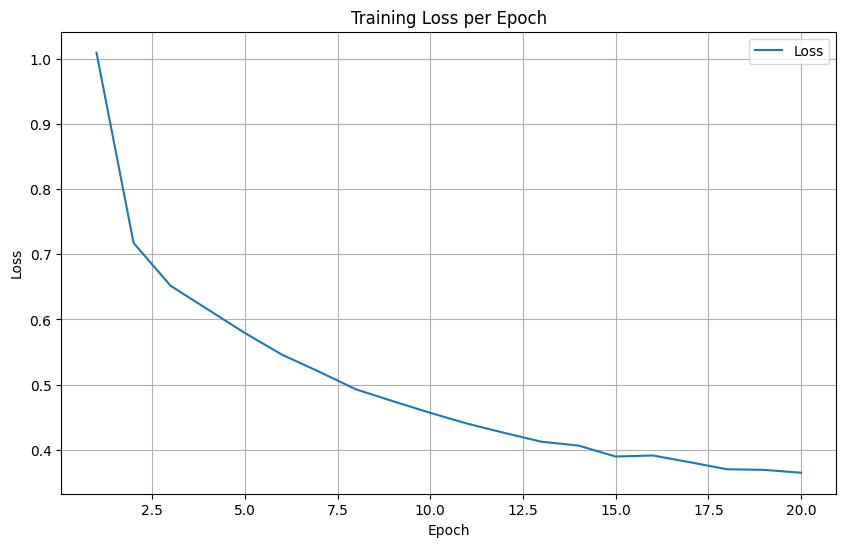

In [9]:
# 학습 기록을 저장할 리스트 생성
loss_history = []
iou_history = []

# 에포크 반복 학습
num_epochs = 20

# 모델을 학습 모드로 전환
model.train()

for epoch in range(1, num_epochs + 1):
    loss = 0.0  # 에포크 당 손실을 저장할 변수 초기화
    iou = 0.0  # 에포크 당 IoU를 저장할 변수 초기화

    # 데이터 로더를 통해 미니배치 학습
    for _, (x, y) in enumerate(train_dataloader):
        optimizer.zero_grad()  # 가중치 초기화

        # 자동 혼합 정밀도 학습 활성화
        with amp.autocast(enabled=amp_enabled):
            y_hat = model(x)  # 모델을 통해 예측값 생성
            batch_loss = criterion(y_hat, y)  # 예측값과 실제값 간의 손실 계산

        # 손실 스케일링 및 역전파
        grad_scaler.scale(batch_loss).backward()
        grad_scaler.step(optimizer)
        grad_scaler.update()

        # 현재 배치의 손실을 numpy 형식으로 변환하여 손실 변수에 추가
        batch_loss = batch_loss.detach().cpu().numpy()
        loss += batch_loss

        # 예측값을 클래스별로 가장 높은 값으로 변환
        preds = torch.argmax(y_hat, dim=1)

        # 현재 배치의 IoU 계산
        batch_iou = batch_mean_iou(preds.detach().cpu().numpy(), y.detach().cpu().numpy())
        iou += batch_iou  # 에포크 IoU에 추가

    # 에포크가 끝날 때마다 평균 손실과 평균 IoU 계산
    loss = loss / len(train_dataloader)
    iou = iou / len(train_dataloader)

    # 손실과 IoU 기록 저장
    loss_history.append(loss)
    iou_history.append(iou)

    # 학습률 스케줄러 업데이트 (ReduceLROnPlateau는 성능에 따라 학습률을 조정)
    scheduler.step(iou)

    # 1 epoch마다 손실과 IoU 출력
    print(f"-------Epoch {epoch}-------")
    print(f"Loss : {loss}")
    print(f"Mean IOU: {iou}")

# 학습이 끝난 후 손실 값 시각화
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), loss_history, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

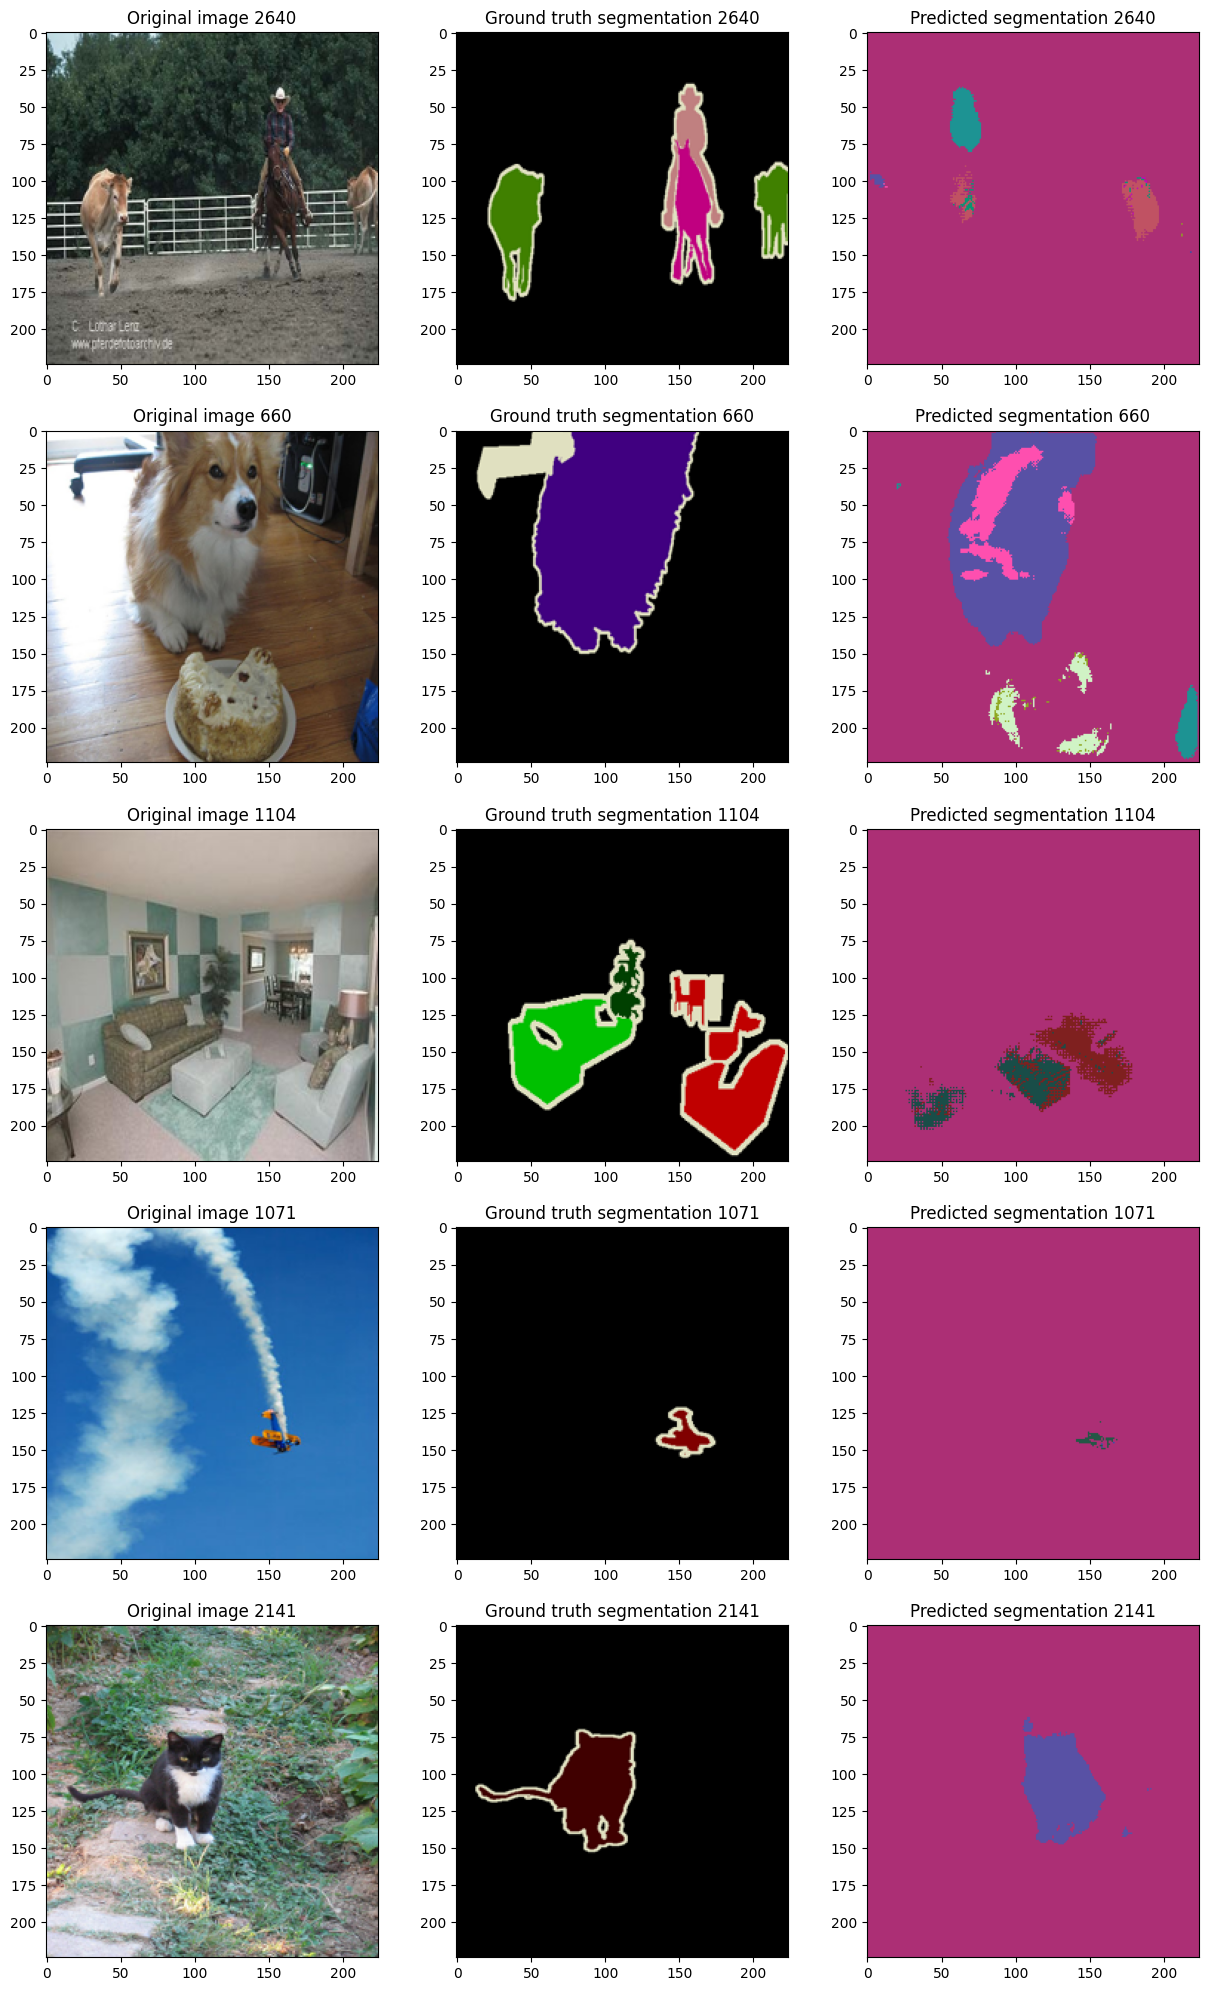

In [10]:
def create_color_index(num_classes):
    np.random.seed(0)  # 결과 재현성을 위해 시드 고정
    color_map = {}
    for i in range(num_classes):
        color_map[i] = np.random.randint(0, 256, size=(3,)).tolist()  # 각 클래스에 대해 [R, G, B] 색상을 생성
    return color_map

import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 모델을 평가 모드로 전환 (드롭아웃, 배치 정규화 비활성화)
model.eval()

# 시각화할 이미지 개수 설정
num_images = 5

# 데이터셋에서 랜덤하게 num_images개의 인덱스를 선택
random_indices = np.random.choice(len(train_dataset), num_images, replace=False)

# 데이터를 반복해서 처리
for idx, random_idx in enumerate(random_indices):
    # 모델 입력으로 사용할 이미지
    x, _ = train_dataset[random_idx]

    # 원본 이미지 로드 (모델 평가 외에 참고용으로 사용)
    y, _ = train_dataset.load_imgs(random_idx)

    # Ground truth 세그멘테이션 이미지 로드
    gt = train_dataset.segmentation_imgs[random_idx]
    gt = Image.open(gt).convert("RGB")  # RGB로 변환

    # 모델 입력 크기 조정 (차원 추가하여 배치 형태로 변경)
    x = x.unsqueeze(0)
    y_hat = model(x)  # 모델로부터 예측 결과 생성
    y_hat = torch.argmax(y_hat, dim=1)[0, :, :]  # 클래스별 예측값 중 가장 높은 값을 선택
    y_hat = y_hat.detach().cpu().numpy()  # numpy 배열로 변환

    # Ground truth 이미지를 모델의 출력 크기(img_size)로 조정
    gt = gt.resize((img_size, img_size))
    gt = np.array(gt)

    # 예측된 클래스의 최대 값을 기반으로 클래스 수 확인
    num_classes = y_hat.max() + 1
    COLOR_2_INDEX = create_color_index(num_classes)

    # 예측된 세그멘테이션 결과를 RGB 컬러로 변환할 빈 배열 생성
    y_hat_mask = np.zeros((img_size, img_size, 3))

    # 예측 결과를 RGB 색상으로 매핑
    for i in range(img_size):
        for j in range(img_size):
            y_hat_mask[i, j, :] = COLOR_2_INDEX[y_hat[i, j]]

    # 결과를 정수형으로 변환
    y_hat_mask = y_hat_mask.astype(int)

    # 시각화
    plt.rcParams['figure.figsize'] = 15, 5 * num_images

    plt.subplot(num_images, 3, 3 * idx + 1)
    plt.imshow(y)
    plt.title(f"Original image {random_idx+1}")

    plt.subplot(num_images, 3, 3 * idx + 2)
    plt.imshow(gt)
    plt.title(f"Ground truth segmentation {random_idx+1}")

    plt.subplot(num_images, 3, 3 * idx + 3)
    plt.imshow(y_hat_mask)
    plt.title(f"Predicted segmentation {random_idx+1}")

plt.show()

In [ ]:
print(np.unique(y_hat))

[0]
